
# Cueing Group Analysis Winter 2019


## Setup



In [1]:
# Standard Pythonic imports
import os,sys,glob,numpy as np, pandas as pd
import scipy
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# MNE functions
from mne import Epochs, find_events, concatenate_raws
from mne.time_frequency import tfr_morlet

# EEG-Noteooks functions
from eegnb.analysis.analysis_utils import load_data
from eegnb.datasets import fetch_dataset

## Load the data



In [2]:
eegnb_data_path = os.path.join(os.path.expanduser('~/'),'.eegnb', 'data')
cueing_data_path = os.path.join(eegnb_data_path, 'visual-cueing', 'kylemathlab_dev')

# If dataset hasn't been downloaded yet, download it
if not os.path.isdir(cueing_data_path):
      fetch_dataset(data_dir=eegnb_data_path, experiment='visual-cueing', site='kylemathlab_dev')

## Put the data into MNE Epochs

Fall 2018
subs = [101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112,
        202, 203, 204, 205, 207, 208, 209, 210, 211, 
        301, 302, 303, 304, 305, 306, 307, 308, 309]

Winter 2019



In [3]:
subs = [1101, 1102, 1103, 1104, 1105, 1106, 1108, 1109, 1110,
        1202, 1203, 1205, 1206, 1209, 1210, 1211, 1215,
        1301, 1302, 1313, 
        1401, 1402, 1403, 1404, 1405,  1408, 1410, 1411, 1412, 1413, 1413, 1414, 1415, 1416]
#
# Both
# subs = [101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112,
#         202, 203, 204, 205, 207, 208, 209, 210, 211, 
#         301, 302, 303, 304, 305, 306, 307, 308, 309,
#         1101, 1102, 1103, 1104, 1105, 1106, 1108, 1109, 1110,
#         1202, 1203, 1205, 1206, 1209, 1210, 1211, 1215,
#         1301, 1302, 1313, 
#         1401, 1402, 1403, 1404, 1405,  1408, 1410, 1411, 1412, 1413, 1413, 1414, 1415, 1416]
#
#
# placeholders to add to for each subject
diff_out = []
Ipsi_out = []
Contra_out = []
Ipsi_spectra_out = []
Contra_spectra_out = []
diff_spectra_out = []
ERSP_diff_out = []
ERSP_Ipsi_out = []
ERSP_Contra_out = []

frequencies =  np.linspace(6, 30, 100, endpoint=True)
wave_cycles = 6

# time frequency window for analysis
f_low = 7 # Hz
f_high = 10
f_diff = f_high-f_low
 
t_low = 0 # s
t_high = 1
t_diff = t_high-t_low

bad_subs= [6, 7, 13, 26]
really_bad_subs = [11, 12, 19]
sub_count = 0    
    
    
    
for sub in subs:
    print(sub)
    
    sub_count += 1

    
    if (sub_count in really_bad_subs):
        rej_thresh_uV = 90
    elif (sub_count in bad_subs):
        rej_thresh_uV = 90
    else:
        rej_thresh_uV = 90

    rej_thresh = rej_thresh_uV*1e-6
    
    
    # Load both sessions
    raw = load_data(sub,1, # subject, session
                    experiment='visual-cueing',site='kylemathlab_dev',device_name='muse2016',
                    data_dir = eegnb_data_path)
                
    raw.append(
          load_data(sub,2, # subject, session
                    experiment='visual-cueing', site='kylemathlab_dev', device_name='muse2016',
                    data_dir = eegnb_data_path))
    

    # Filter Raw Data
    raw.filter(1,30, method='iir')

    #Select Events
    events = find_events(raw)
    event_id = {'LeftCue': 1, 'RightCue': 2}
    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=-1, tmax=2, baseline=(-1, 0), 
                    reject={'eeg':rej_thresh}, preload=True,
                    verbose=False, picks=[0, 3])
    print('Trials Remaining: ' + str(len(epochs.events)) + '.')

    # Compute morlet wavelet
    # Left Cue
    tfr, itc = tfr_morlet(epochs['LeftCue'], freqs=frequencies, 
                          n_cycles=wave_cycles, return_itc=True)
    tfr = tfr.apply_baseline((-1,-.5),mode='mean')
    power_Ipsi_TP9 = tfr.data[0,:,:]
    power_Contra_TP10 = tfr.data[1,:,:]

    # Right Cue
    tfr, itc = tfr_morlet(epochs['RightCue'], freqs=frequencies, 
                          n_cycles=wave_cycles, return_itc=True)
    tfr = tfr.apply_baseline((-1,-.5),mode='mean')
    power_Contra_TP9 = tfr.data[0,:,:]
    power_Ipsi_TP10 = tfr.data[1,:,:]

    # Compute averages Differences
    power_Avg_Ipsi =   (power_Ipsi_TP9+power_Ipsi_TP10)/2;
    power_Avg_Contra = (power_Contra_TP9+power_Contra_TP10)/2;
    power_Avg_Diff = power_Avg_Ipsi-power_Avg_Contra;
    
    #output data into array
    times = epochs.times
    Ipsi_out.append(np.mean(power_Avg_Ipsi[np.argmax(frequencies>f_low):
                                           np.argmax(frequencies>f_high)-1,
                            np.argmax(times>t_low):np.argmax(times>t_high)-1 ]
                           )
                   )            
    Ipsi_spectra_out.append(np.mean(power_Avg_Ipsi[:,np.argmax(times>t_low):
                                                   np.argmax(times>t_high)-1 ],1
                                   )
                           )
        
    Contra_out.append(np.mean(power_Avg_Contra[np.argmax(frequencies>f_low):
                                               np.argmax(frequencies>f_high)-1,
                            np.argmax(times>t_low):np.argmax(times>t_high)-1 ]
                             )
                     )
    
    Contra_spectra_out.append(np.mean(power_Avg_Contra[:,np.argmax(times>t_low):
                                                       np.argmax(times>t_high)-1 ],1))
    
    
    diff_out.append(np.mean(power_Avg_Diff[np.argmax(frequencies>f_low):
                                           np.argmax(frequencies>f_high)-1,
                            np.argmax(times>t_low):np.argmax(times>t_high)-1 ]
                           )
                   )
    diff_spectra_out.append(np.mean(power_Avg_Diff[:,np.argmax(times>t_low):
                                                   np.argmax(times>t_high)-1 ],1
                                   )
                           )
    
    #save the spectrograms to average over after
    ERSP_diff_out.append(power_Avg_Diff)
    ERSP_Ipsi_out.append(power_Avg_Ipsi)
    ERSP_Contra_out.append(power_Avg_Contra)

1101


Loading these files: 

C:\Users\pavit\.eegnb\data\visual-cueing\kylemathlab_dev\muse2016\subject1101\session001\subject1101_session1_recording_2019-03-26-20.08.20.csv




['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
Creating RawArray with float64 data, n_channels=6, n_times=61284
    Range : 0 ... 61283 =      0.000 ...   239.387 secs
Ready.


Loading these files: 

C:\Users\pavit\.eegnb\data\visual-cueing\kylemathlab_dev\muse2016\subject1101\session002\subject1101_session2_recording_2019-03-26-20.16.25.csv




['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
Creating RawArray with float64 data, n_channels=6, n_times=61296
    Range : 0 ... 61295 =      0.000 ...   239.434 secs
Ready.
Filtering raw data in 2 contiguous segments
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and rev

## Combine subjects



In [4]:
#average spectrograms
GrandAvg_diff = np.nanmean(ERSP_diff_out,0)
GrandAvg_Ipsi = np.nanmean(ERSP_Ipsi_out,0)
GrandAvg_Contra = np.nanmean(ERSP_Contra_out,0)

#average spectra
GrandAvg_spec_Ipsi = np.nanmean(Ipsi_spectra_out,0)
GrandAvg_spec_Contra = np.nanmean(Contra_spectra_out,0)
GrandAvg_spec_diff = np.nanmean(diff_spectra_out,0)

#error bars for spectra (standard error)
num_good = len(diff_out) - sum(np.isnan(diff_out))   
GrandAvg_spec_Ipsi_ste = np.nanstd(Ipsi_spectra_out,0)/np.sqrt(num_good)
GrandAvg_spec_Contra_ste = np.nanstd(Contra_spectra_out,0)/np.sqrt(num_good)
GrandAvg_spec_diff_ste = np.nanstd(diff_spectra_out,0)/np.sqrt(num_good)

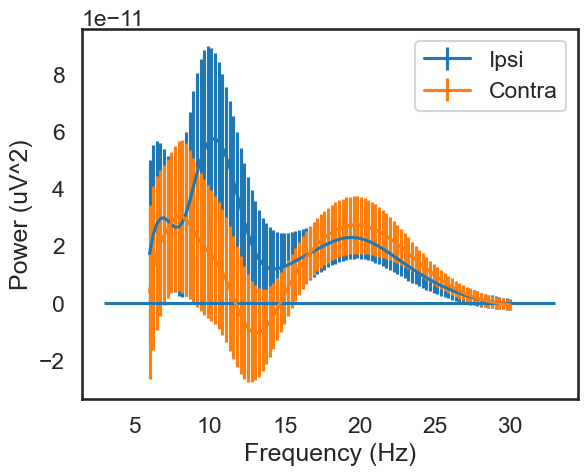

In [5]:
#Plot Spectra error bars
fig, ax = plt.subplots(1)
plt.errorbar(frequencies,GrandAvg_spec_Ipsi,yerr=GrandAvg_spec_Ipsi_ste)
plt.errorbar(frequencies,GrandAvg_spec_Contra,yerr=GrandAvg_spec_Contra_ste)
plt.legend(('Ipsi','Contra'))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (uV^2)')   
plt.hlines(0,3,33)

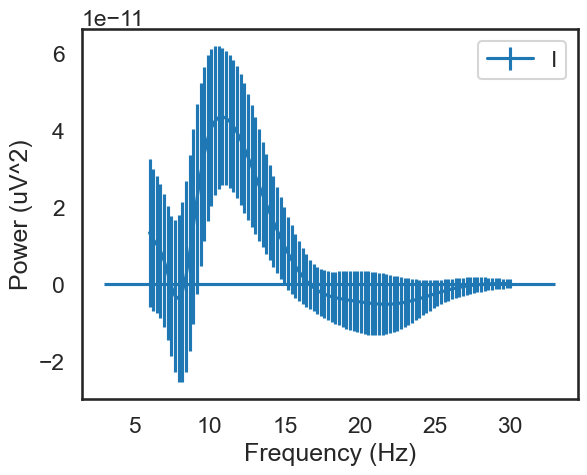

In [6]:
#Plot Spectra Diff error bars
fig, ax = plt.subplots(1)
plt.errorbar(frequencies,GrandAvg_spec_diff,yerr=GrandAvg_spec_diff_ste)
plt.legend('Ipsi-Contra')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (uV^2)')   
plt.hlines(0,3,33)

Grand Average Ipsi



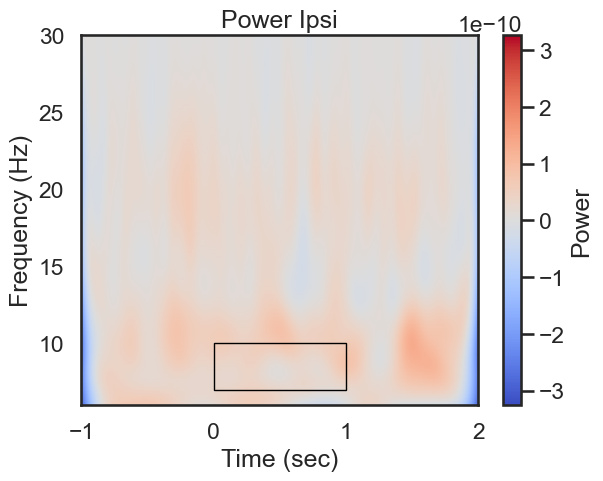

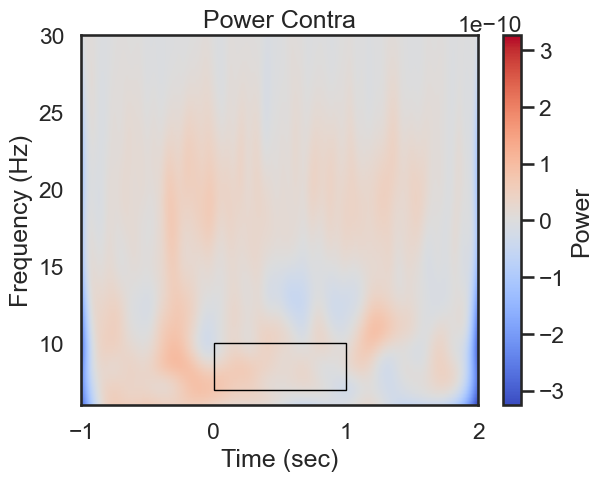

In [7]:
plot_max = np.max([np.max(np.abs(GrandAvg_Ipsi)), np.max(np.abs(GrandAvg_Contra))])  
fig, ax = plt.subplots(1)
im = plt.imshow(GrandAvg_Ipsi,
           extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
           aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max, vmax=plot_max)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Power Ipsi')
cb = fig.colorbar(im)
cb.set_label('Power')
# Create a Rectangle patch
rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
#
##e#################################################################################################
#
# Grand Average Contra
#
fig, ax = plt.subplots(1)
im = plt.imshow(GrandAvg_Contra,
           extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
           aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max, vmax=plot_max)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Power Contra')
cb = fig.colorbar(im)
cb.set_label('Power')
# Create a Rectangle patch
rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
#

Grand Average Ipsi-Contra Difference




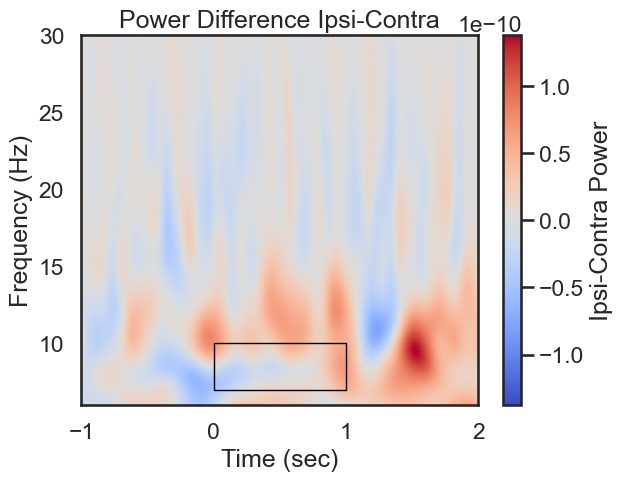

In [8]:
plot_max_diff = np.max(np.abs(GrandAvg_diff))
fig, ax = plt.subplots(1)
im = plt.imshow(GrandAvg_diff,
           extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
           aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max_diff, vmax=plot_max_diff)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Power Difference Ipsi-Contra')
cb = fig.colorbar(im)
cb.set_label('Ipsi-Contra Power')
# Create a Rectangle patch
rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

## Compute t test



In [9]:
num_good = len(diff_out) - sum(np.isnan(diff_out))

[tstat, pval] = scipy.stats.ttest_ind(diff_out,np.zeros(len(diff_out)),nan_policy='omit')
print('Ipsi Mean: '+  str(np.nanmean(Ipsi_out))) 
print('Contra Mean: '+  str(np.nanmean(Contra_out))) 
print('Mean Diff: '+  str(np.nanmean(diff_out))) 
print('t(' + str(num_good-1) + ') = ' + str(round(tstat,3)))
print('p = ' + str(round(pval,3)))

Ipsi Mean: 3.5735930197157026e-11
Contra Mean: 2.6421745679207317e-11
Mean Diff: 9.314184517949714e-12
t(30) = 0.456
p = 0.65


## Save average powers ipsi and contra



In [10]:
print(diff_out)
raw_data = {'Ipsi Power': Ipsi_out, 
        'Contra Power': Contra_out}
df = pd.DataFrame(raw_data, columns = ['Ipsi Power', 'Contra Power'])
print(df)
df.to_csv('375CueingEEG.csv')
print('Saved subject averages for each condition to 375CueingEEG.csv file in present directory')

[np.float64(nan), np.float64(1.7890047693697175e-11), np.float64(6.402571924638044e-11), np.float64(1.2016988558064717e-10), np.float64(1.6436811298970802e-10), np.float64(1.1465401250727375e-10), np.float64(8.107123680349162e-11), np.float64(-3.1169419915324276e-11), np.float64(6.493727108357469e-11), np.float64(4.352931438541606e-11), np.float64(2.8760356184521733e-11), np.float64(3.773350340044495e-11), np.float64(2.113134995947909e-11), np.float64(1.5571207459949488e-10), np.float64(-4.629115067550072e-10), np.float64(-8.052232335321788e-11), np.float64(-4.664422137282262e-11), np.float64(nan), np.float64(nan), np.float64(-3.438951097875037e-11), np.float64(7.091042185483073e-11), np.float64(1.2983383558014306e-11), np.float64(1.3604198590381474e-10), np.float64(-5.861633427481529e-11), np.float64(-6.204912953285819e-11), np.float64(1.8344086913139518e-10), np.float64(2.380242500968443e-11), np.float64(-8.805033297719281e-11), np.float64(-7.50812894725384e-11), np.float64(2.9079648

## Save spectra



In [11]:
df = pd.DataFrame(Ipsi_spectra_out,columns=frequencies)
print(df)
df.to_csv('375CueingIpsiSpec.csv')

df = pd.DataFrame(Contra_spectra_out,columns=frequencies)
df.to_csv('375CueingContraSpec.csv')
print('Saved Spectra to 375CueingContraSpec.csv file in present directory')

       6.000000      6.242424      6.484848      6.727273      6.969697   \
0            NaN           NaN           NaN           NaN           NaN   
1   7.991890e-11  8.036284e-11  7.548816e-11  6.696746e-11  5.489871e-11   
2   8.482874e-11  8.635330e-11  9.420775e-11  1.024297e-10  1.064200e-10   
3   1.394826e-10  1.324403e-10  1.241198e-10  1.121430e-10  9.387917e-11   
4   1.355015e-10  1.519385e-10  1.523882e-10  1.378647e-10  1.137803e-10   
5   4.146935e-11  4.747567e-11  5.477697e-11  6.351733e-11  7.302017e-11   
6   1.591767e-10  1.802644e-10  1.960184e-10  2.090976e-10  2.218464e-10   
7   2.051924e-10  1.359738e-10  7.068325e-11  1.696284e-11 -2.275222e-11   
8  -2.289620e-11 -1.966269e-11 -1.143603e-11 -6.869489e-13  1.008869e-11   
9   2.639212e-10  2.390503e-10  2.144125e-10  1.905306e-10  1.680688e-10   
10  1.734091e-10  1.751927e-10  1.753140e-10  1.718332e-10  1.640584e-10   
11 -4.155194e-11  5.554974e-11  1.555793e-10  2.462566e-10  3.218309e-10   
12  1.132429